# ケーブルコネクタコンペのチュートリアル 物体検出・クラス分類編 YOLOv5

### はじめに
* このチュートリアルではYOLOを用いた物体検出・クラス分類の学習・推論を行う方法について紹介します。
    * YOLOv5で学習を行うためのデータ加工方法、YOLOv5で推論を行ったときの出力フォーマットについて紹介します。
    * YOLOv5での推論は物体検出の座標、クラス、確信度を出力することができるのですが、このチュートリアルではこのクラスをもとにsubmission.csvを作成するところまで行います。
* 別で公開したefficientnetとのアンサンブルを行ったり、YOLOv5で物体検出を行い背景を除去した上でefficientnetクラス分類を行ったりいろいろな手法が試せるかと思いますので是非ご活用いただければと思います。

### 目次
* ColabでYOLOv5実行環境構築
* YOLOv5 学習用データ作成
* YOLOv5 学習
* YOLOv5 推論
* submission.csv作成


In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


## ColabでYOLOv5実行環境構築
以下のgithubよりyolov5レポジトリをクローンしrequirements.txtに記載のライブラリのインストールする
* https://github.com/ultralytics/yolov5

In [3]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 9876, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 9876 (delta 3), reused 5 (delta 3), pack-reused 9868
Receiving objects: 100% (9876/9876), 10.08 MiB | 18.66 MiB/s, done.
Resolving deltas: 100% (6869/6869), done.


In [4]:
%cd yolov5/
!pip install -qr requirements.txt

/content/yolov5
     |████████████████████████████████| 596 kB 8.0 MB/s 


In [5]:
!ls "/content/yolov5"

CONTRIBUTING.md  Dockerfile  LICENSE	requirements.txt  utils
data		 export.py   models	train.py	  val.py
detect.py	 hubconf.py  README.md	tutorial.ipynb


In [5]:
!ls "/content/drive/My Drive/Python/Kaggle/nishika/resize_data"

additional_data		   df_train_resized.csv  train
additional_resize_jpg.zip  test			 train_resize_jpg.zip
df_additional_resized.csv  test_resize_jpg.zip


### 画像データをマイドライブからコピーしcontentへ展開
* コンペページより入手できる画像データを使うのではなく、別のチュートリアルで公開したresize後の画像データを使っております。※ reseize後はサイズを512,512に統一しております。
* オリジナルの画像はサイズが非常に大きいため、resize後の画像を使って効率的に学習を行います。

In [6]:
!mkdir datasets

### data.zipから解凍する

#!cp "/content/drive/My Drive/Python/Kaggle/nishika/data.zip" /content/

#!unzip /content/data.zip -d "/content/datasets"

#!unzip /content/datasets/train_image.zip -d "/content/datasets/"
#!unzip /content/datasets/test_image.zip -d "/content/datasets/"
#!unzip /content/datasets/additional_image.zip -d "/content/datasets/"


### マイドライブのresize jpgから解凍する
!cp "/content/drive/My Drive/Python/Kaggle/nishika/resize_data/train_resize_jpg.zip" /content/
!cp "/content/drive/My Drive/Python/Kaggle/nishika/resize_data/test_resize_jpg.zip" /content/
!cp "/content/drive/My Drive/Python/Kaggle/nishika/resize_data/additional_resize_jpg.zip" /content/


!unzip /content/train_resize_jpg.zip -d "/content/datasets"
!unzip /content/test_resize_jpg.zip -d "/content/datasets"
!unzip /content/additional_resize_jpg.zip -d "/content/datasets"


ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: /content/datasets/train/836477d3.jpg  
  inflating: /content/datasets/train/8379c02e.jpg  
  inflating: /content/datasets/train/83a0a065.jpg  
  inflating: /content/datasets/train/83ba9bed.jpg  
  inflating: /content/datasets/train/83c7b7f6.jpg  
  inflating: /content/datasets/train/83f317ef.jpg  
  inflating: /content/datasets/train/845548b9.jpg  
  inflating: /content/datasets/train/84961ee2.jpg  
  inflating: /content/datasets/train/84bdcd15.jpg  
  inflating: /content/datasets/train/84d133d9.jpg  
  inflating: /content/datasets/train/84d5d511.jpg  
  inflating: /content/datasets/train/8506ef9d.jpg  
  inflating: /content/datasets/train/854c9a6a.jpg  
  inflating: /content/datasets/train/856aca9a.jpg  
  inflating: /content/datasets/train/85a915d1.jpg  
  inflating: /content/datasets/train/85c525b0.jpg  
  inflating: /content/datasets/train/85c7fe93.jpg  
  inflating: /content/datasets/train/85ffd4a3.jpg  
  inflating: /content/datasets/t

In [7]:
import numpy as np
import pandas as pd
from pathlib import Path

import torch
from torch import nn, optim
from  torch.utils.data import Dataset, DataLoader

from glob import glob
from matplotlib import pyplot as plt

import os, random, gc
import re, time, json
from  ast import literal_eval
import ast

from sklearn.metrics import label_ranking_average_precision_score

from tqdm.notebook import tqdm
import joblib

from  sklearn.model_selection  import StratifiedKFold
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder

from IPython.display import Image, clear_output 

In [8]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

SEED = 42

In [9]:
!ls "/content/datasets"

additional_data  test  train


In [9]:
## For colab
DATA_ROOT = "/content/datasets/"
TRAIN_IMAGES_ROOT = "/content/datasets/train/"
TEST_IMAGES_ROOT = "/content/datasets/test/"
ADDITIONAL_IMAGES_ROOT="/content/datasets/additional_data/"

##################################################################
###   自分の環境に合わせる
##################################################################

MYDRIVE = "/content/drive/My Drive/Python/Kaggle/nishika/"
OUTPUT = "/content/drive/My Drive/Python/Kaggle/nishika/output/"


In [10]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", DEVICE)

Device: cpu


In [11]:
### 画像縮小チュートリアルで作成したresized後の物体検出アノテーションがあるデータフレームの読み込み

df_train = pd.read_csv(MYDRIVE+"resize_data/df_train_resized.csv")
df_train

,filename,Xmin_Ymin_Xmax_Ymax,class,resized_box
0,2f71963a.jpg,"[921, 1510, 1558, 2207]",HDMI,"[156, 192, 264, 280]"
1,8cdf4bda.jpg,"[1442, 1525, 1722, 2000]",USB_Mini,"[244, 194, 292, 254]"
2,7ac35f30.jpg,"[666, 1671, 1990, 2259]",Dock,"[113, 212, 337, 287]"
3,f6641c06.jpg,"[1242, 1753, 1789, 2115]",Lightning,"[210, 223, 303, 269]"
4,4fdc8d7d.jpg,"[1572, 1050, 2231, 1691]",USB_Micro_B,"[266, 133, 378, 215]"
...,...,...,...,...
2366,f51ca7d8.jpg,"[678, 1276, 2088, 2355]",USB_Type_B,"[115, 162, 354, 299]"
2367,323b4f3c.jpg,"[1564, 2003, 2116, 2307]",USB_Type_C,"[267, 256, 361, 295]"
2368,5f60288f.jpg,"[1273, 1816, 2275, 2784]",RJ_45,"[216, 231, 385, 354]"
2369,eaea09d6.jpg,"[863, 1838, 1213, 2054]",USB_Micro_B,"[205, 245, 288, 274]"


In [12]:
df_test = pd.read_csv(MYDRIVE+"/sample_submission.csv")
df_test

,filename,class
0,997195ba.jpg,USB_Type_C
1,9f3f263d.jpg,USB_Type_C
2,1072aa7d.jpg,USB_Type_C
3,f8047293.jpg,USB_Type_C
4,3dccb562.jpg,USB_Type_C
...,...,...
2195,4eae2d46.jpg,USB_Type_C
2196,ceadcae4.jpg,USB_Type_C
2197,4a5a3544.jpg,USB_Type_C
2198,bbc3c7b6.jpg,USB_Type_C


In [13]:
df_additional = pd.read_csv(MYDRIVE+"resize_data/df_additional_resized.csv")
df_additional

,filename,filename_trim,class,path
0,172e1676.jpg,172e1676_trim.jpg,USB_Micro_B_W,/content/datasets/additional/172e1676.jpg
1,2ed927e9.jpg,2ed927e9_trim.jpg,USB_Mini,/content/datasets/additional/2ed927e9.jpg
2,d62e1c29.jpg,d62e1c29_trim.jpg,HDMI,/content/datasets/additional/d62e1c29.jpg
3,e0ccc43c.jpg,e0ccc43c_trim.jpg,VGA,/content/datasets/additional/e0ccc43c.jpg
4,d6a40317.jpg,d6a40317_trim.jpg,Lightning_T,/content/datasets/additional/d6a40317.jpg
...,...,...,...,...
1643,1a42d526.jpg,1a42d526_trim.jpg,Lightning,/content/datasets/additional/1a42d526.jpg
1644,6b3c238e.jpg,6b3c238e_trim.jpg,USB_Type_C,/content/datasets/additional/6b3c238e.jpg
1645,587a4905.jpg,587a4905_trim.jpg,USB_Mini,/content/datasets/additional/587a4905.jpg
1646,ae600959.jpg,ae600959_trim.jpg,USB_Type_C,/content/datasets/additional/ae600959.jpg


In [14]:
### content/datasetsに置いたtrain画像のパスを取得してdf_trainへマージ

train_paths = glob(TRAIN_IMAGES_ROOT+"/*.jpg")

df_train_path = pd.DataFrame({
    "path": train_paths,
})
df_train_path["filename"] = df_train_path["path"].apply(lambda x: x.split("/")[-1][:-4])
df_train["filename"] = df_train["filename"].apply(lambda x: x[:-4])

df_train = pd.merge(df_train, df_train_path, on='filename')
df_train

,filename,Xmin_Ymin_Xmax_Ymax,class,resized_box,path
0,2f71963a,"[921, 1510, 1558, 2207]",HDMI,"[156, 192, 264, 280]",/content/datasets/train/2f71963a.jpg
1,8cdf4bda,"[1442, 1525, 1722, 2000]",USB_Mini,"[244, 194, 292, 254]",/content/datasets/train/8cdf4bda.jpg
2,7ac35f30,"[666, 1671, 1990, 2259]",Dock,"[113, 212, 337, 287]",/content/datasets/train/7ac35f30.jpg
3,f6641c06,"[1242, 1753, 1789, 2115]",Lightning,"[210, 223, 303, 269]",/content/datasets/train/f6641c06.jpg
4,4fdc8d7d,"[1572, 1050, 2231, 1691]",USB_Micro_B,"[266, 133, 378, 215]",/content/datasets/train/4fdc8d7d.jpg
...,...,...,...,...,...
2366,f51ca7d8,"[678, 1276, 2088, 2355]",USB_Type_B,"[115, 162, 354, 299]",/content/datasets/train/f51ca7d8.jpg
2367,323b4f3c,"[1564, 2003, 2116, 2307]",USB_Type_C,"[267, 256, 361, 295]",/content/datasets/train/323b4f3c.jpg
2368,5f60288f,"[1273, 1816, 2275, 2784]",RJ_45,"[216, 231, 385, 354]",/content/datasets/train/5f60288f.jpg
2369,eaea09d6,"[863, 1838, 1213, 2054]",USB_Micro_B,"[205, 245, 288, 274]",/content/datasets/train/eaea09d6.jpg


In [15]:
### Xmin_Ymin_Xmax_Ymaxはread_csvするとstr型なので、リストで扱えるように変換
df_train["Xmin_Ymin_Xmax_Ymax"] = [ast.literal_eval(d) for d in df_train["Xmin_Ymin_Xmax_Ymax"]]
df_train["resized_box"] = [ast.literal_eval(d) for d in df_train["resized_box"]]

In [16]:
df_train['connector']='connector'

In [17]:
df_additional['connector']='connector'
df_additional

,filename,filename_trim,class,path,connector
0,172e1676.jpg,172e1676_trim.jpg,USB_Micro_B_W,/content/datasets/additional/172e1676.jpg,connector
1,2ed927e9.jpg,2ed927e9_trim.jpg,USB_Mini,/content/datasets/additional/2ed927e9.jpg,connector
2,d62e1c29.jpg,d62e1c29_trim.jpg,HDMI,/content/datasets/additional/d62e1c29.jpg,connector
3,e0ccc43c.jpg,e0ccc43c_trim.jpg,VGA,/content/datasets/additional/e0ccc43c.jpg,connector
4,d6a40317.jpg,d6a40317_trim.jpg,Lightning_T,/content/datasets/additional/d6a40317.jpg,connector
...,...,...,...,...,...
1643,1a42d526.jpg,1a42d526_trim.jpg,Lightning,/content/datasets/additional/1a42d526.jpg,connector
1644,6b3c238e.jpg,6b3c238e_trim.jpg,USB_Type_C,/content/datasets/additional/6b3c238e.jpg,connector
1645,587a4905.jpg,587a4905_trim.jpg,USB_Mini,/content/datasets/additional/587a4905.jpg,connector
1646,ae600959.jpg,ae600959_trim.jpg,USB_Type_C,/content/datasets/additional/ae600959.jpg,connector


### resize後のデータでBOXを可視化

In [18]:
from skimage import exposure
import cv2

def read_img(path):
    data = cv2.imread(path)
    
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data 

def plot_img(img, size=(7, 7), is_rgb=True, title="", cmap='gray'):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

def plot_imgs(imgs, cols=4, size=7, is_rgb=True, title="", cmap='gray', img_size=(500,500)):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

filepath---> 28d290d0 ,  img shape---> (512, 512, 3) ,  Annotation---> [185, 202, 327, 310]
filepath---> 8a974516 ,  img shape---> (512, 512, 3) ,  Annotation---> [231, 125, 374, 233]
filepath---> 603153b4 ,  img shape---> (512, 512, 3) ,  Annotation---> [196, 227, 330, 265]
filepath---> 3e38e73a ,  img shape---> (512, 512, 3) ,  Annotation---> [179, 167, 337, 281]
filepath---> 3865e98e ,  img shape---> (512, 512, 3) ,  Annotation---> [106, 169, 303, 355]
filepath---> bb8d629a ,  img shape---> (512, 512, 3) ,  Annotation---> [175, 257, 274, 297]
filepath---> a31497a1 ,  img shape---> (512, 512, 3) ,  Annotation---> [173, 179, 435, 273]
filepath---> beff790a ,  img shape---> (512, 512, 3) ,  Annotation---> [209, 232, 308, 266]


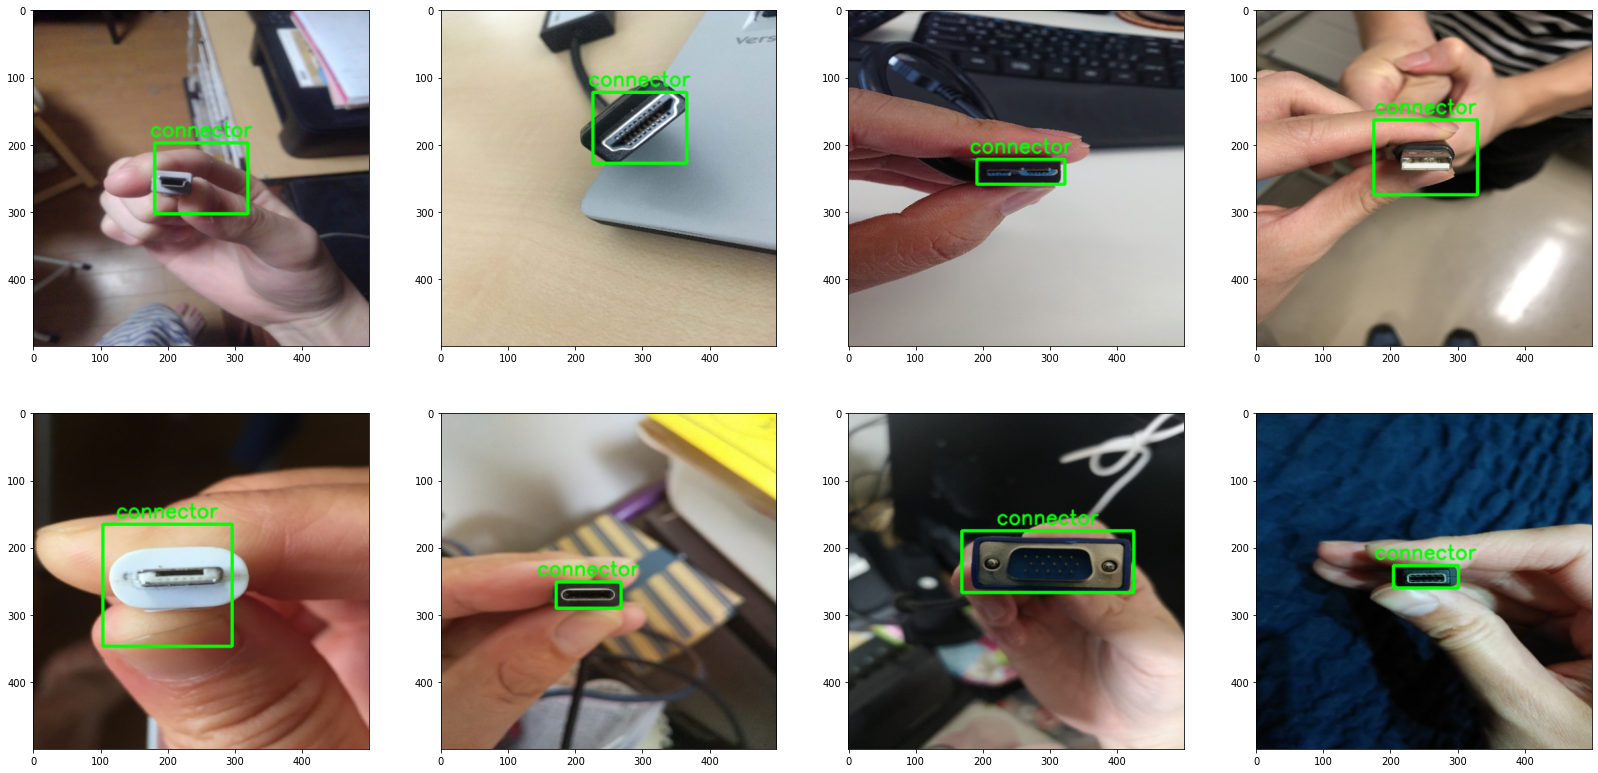

In [19]:
imgs = []

color = [0,255,0]     

thickness = 10
scale = 1
FONT = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 5
FONT_THICKNESS = 10
FONT_LINE_TYPE = cv2.LINE_AA

N_read = 8
startid = np.random.randint(0,len(df_train)-N_read)

for _, row in df_train.iloc[startid:startid+N_read].iterrows():
    #study_id = row["class"]
    study_id = row["connector"]
    img_path = row['path']
    
    #img = np.load(img_path)
    img = read_img(img_path)

    img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
 
    print("filepath--->", row['filename'], ",  img shape--->", img.shape, ",  Annotation--->", row['resized_box'])
 
    #target = row["class"]
    target = row["connector"]
    box = row['resized_box']

    if img.shape[0]*img.shape[0] > 2400000:
        thickness = 10
        FONT_SCALE = 5
        FONT_THICKNESS = 10
    else:
        thickness = 3
        FONT_SCALE = 1
        FONT_THICKNESS = 2

    text_width, text_height = cv2.getTextSize(target, FONT, FONT_SCALE, FONT_THICKNESS)[0]

    img = cv2.rectangle(
        img,

        (int(box[0]/scale), int(box[1]/scale)),
        (int(box[2]/scale), int(box[3]/scale)),

        color, thickness
    )
    box_width = int(box[2]/scale) - int(box[0]/scale)
    
    img = cv2.putText(img, target, (int(box[0]/scale)-(text_width-box_width)//2, int(box[1]/scale)-10),
                    FONT, FONT_SCALE, color, FONT_THICKNESS, FONT_LINE_TYPE)       
        
    img = cv2.resize(img, (512,512))
    imgs.append(img)
    
plot_imgs(imgs, cmap=None)

## YOLOv5 学習用データ作成

以下のデータを準備する必要があり、このnotebookでは以下のようなディレクトリ構造になるようにデータを作成していきます。  

* 準備が必要なデータ
    * 画像データ train/val
    * labelデータ(txtファイル) train/val
        * class x_center y_center width heightの形式になっている必要があります。またclassはintないしfloatである必要があります。
        * 座標データは0~1のスケールに変換する必要があります。
        * 今回はXmin Ymin Xmax Ymaxの形式でデータを配布しておりますがこれをYolo向けに変換する処理が必要になります。
        *  labelデータの例
        ```
        13 0.453125 0.6298828125 0.1484375 0.126953125 
        ```
    * 画像データのパスが一覧で記載されているデータ(txtファイル) train/val
        * imageフォルダ以下に置いてある画像のパスを改行区切り(\n)で全て記載
        * 画像データのパスが一覧で記載されている例
        ```
        /content/datasets/images/train/b4a9c08c.jpg\n/content/datasets/images/train/d7ccad3f.jpg\n/content/datasets/images/train/b8dab8a0.jpg\n
        ```
    * 以下の情報が記載されたyaml
        * train = train画像パスが一覧になっているtxtファイルのパス
        * val = val画像パスが一覧になっているtxtファイルのパス
        * nc = 分類するクラス数
        * names = クラスの名前が記載されているdict
 ```
 data = dict(
    train = '/content/train.txt' ,
    val   = '/content/val.txt',
    nc   = 15,
    names = classes
)
 ```

* 上記のデータは以下のようなティレクトリ構成になるように配置します。
```
<content>
　├val.txt
　├train.txt
　├sanwa.yaml
　└<datasets>
    ├<images>
    │　├<val>
    │　│　├f64d3578.jpg
    │　│　├88e1a9ff.jpg
    │　│　├15e31b3b.jpg
    │　│　├da5d2641.jpg
    │　│　 ...
    │　└<train>
    │　　　├b4a9c08c.jpg
    │　　　├d7ccad3f.jpg
    │　　　├b8dab8a0.jpg
    │　　　├e68adee7.jpg
    │　   　 ...
    └<labels>
        ├<val>
        │　├993bd943.txt
        │　├de3ab843.txt
        │　├7cbd0054.txt
        │　├bda5459a.txt
        │　 ...
        └<train>
        ├c54bea44.txt
        ├94acb909.txt
        ├965aa125.txt
        ├5f8d869f.txt
        ...
```

In [20]:
### コンペで配布された物体検出アノテーションをYoloで学習できる形式へ変換
### Xmin Ymin Xmax Ymaxの形式からx_center y_center width heightの形式へ変更しさらに0~1のスケールへと変換

def convert2yolo(size, box):
    dw = 1./size[1]
    dh = 1./size[0]
    x_center = (box[0] + box[2])/2.0
    y_center = (box[1] + box[3])/2.0
    w = box[2] - box[0]
    h = box[3] - box[1]
    x_center = x_center*dw
    w = w*dw
    y_center = y_center*dh
    h = h*dh
    return x_center,y_center,w,h

In [21]:
### TrainとValへ分割

n_splits=5
seed=SEED

df = df_train.copy()

skf = StratifiedKFold(n_splits=n_splits, random_state=seed, shuffle=True)   ### KFOLDのlabal分布に偏りがないようにするために、StatifilyedKFold

#splits = skf.split(np.arange(len(df)), y=df["class"].values)                    ### statifiedのために、idと、 labelのセットをわたす。
splits = skf.split(np.arange(len(df)), y=df["connector"].values)  
df["fold"] = -1

for fold, (train_set, val_set) in enumerate(splits):
    
    df.loc[df.index[val_set], "fold"] = fold                        ### foldid列を作成

In [22]:
df_train = df[df["fold"] != 4]
df_valid = df[df["fold"] == 4]

In [ ]:
dict_label = {0: 'DisplayPort',
 1: 'Dock',
 2: 'HDMI',
 3: 'Lightning',
 4: 'Lightning_T',
 5: 'Mini_DisplayPort',
 6: 'RJ_45',
 7: 'USB_Micro_B',
 8: 'USB_Micro_B_3.1',
 9: 'USB_Micro_B_W',
 10: 'USB_Mini',
 11: 'USB_Type_A',
 12: 'USB_Type_B',
 13: 'USB_Type_C',
 14: 'VGA'}

In [ ]:
dict_id2class = { k:v for v,k in dict_label.items() }

In [23]:
dict_label = {0: 'connector',
}
dict_id2class = { k:v for v,k in dict_label.items() }

### labelデータ作成
Yolo向けに変換されたlabelデータ(class 物体検出アノテーション)を以下のような構成になるように保存
```
<content>
　└<datasets>
  └<labels>
      ├<val>
      │　├993bd943.txt
      │　├de3ab843.txt
      │　├7cbd0054.txt
      │　├bda5459a.txt
      └<train>
        ├c54bea44.txt
        ├94acb909.txt
        ├965aa125.txt
```

In [27]:
!mkdir /content/datasets/images_extract
!mkdir /content/datasets/labels_extract

In [28]:
### label train編
#os.makedirs(DATA_ROOT+"labels/train", exist_ok = True)
os.makedirs(DATA_ROOT+"labels/train_extract", exist_ok = True)

label_root = "/content/datasets/labels/train_extract/"

#for (id_, label, box) in zip(df_train["filename"].values, df_train["class"].values, df_train["resized_box"].values):
for (id_, label, box) in zip(df_train["filename"].values, df_train["connector"].values, df_train["resized_box"].values):
    id_txt = id_ + ".txt"
    txtfile = label_root+id_txt

    x_center,y_center,w,h = convert2yolo(size=[512,512],box=box)

    body = str(dict_id2class[label])+' '+str(x_center) +' '+str(y_center)+' '+str(w)+' '+str(h)+' '

    with open(txtfile, mode="w") as f:
        f.write(body)
        f.write('\n')


In [70]:
!ls /content/datasets/labels/train_extract/

000c15d0.txt  3309e388.txt  6686fc4c.txt  9b6dc423.txt	cfcd8cf0.txt
0013fa17.txt  3320051c.txt  66945e57.txt  9b8f2fa4.txt	cfe0815a.txt
00150bc1.txt  335a0d34.txt  66c2d265.txt  9ba37a22.txt	cfe35c9e.txt
004c5505.txt  337afa43.txt  66fee178.txt  9ba6443e.txt	cfef26c8.txt
005fc418.txt  33c62a2a.txt  670a7f46.txt  9c141384.txt	cff5ce09.txt
007d45c8.txt  33d9f452.txt  670b08a8.txt  9c30538e.txt	d03e5974.txt
00a4d448.txt  343e4608.txt  67175aa0.txt  9c3a6731.txt	d0548e87.txt
00b8f2fd.txt  3457320a.txt  6724425c.txt  9c55b07c.txt	d054bfc7.txt
00f3ca2e.txt  347213dd.txt  672947e3.txt  9cd129f8.txt	d08553fb.txt
010b9063.txt  34c4365a.txt  6739d7f3.txt  9cd7e101.txt	d088c0dc.txt
012b946b.txt  34d17aed.txt  678f2f24.txt  9d4244b0.txt	d09827d9.txt
01375f53.txt  34e3f069.txt  679e7aaf.txt  9d798c6d.txt	d0c5c22b.txt
01ab41be.txt  34ed0cec.txt  67a6e876.txt  9d95bba7.txt	d0ea2828.txt
01b1ae25.txt  34fbd3ea.txt  67d9df3b.txt  9d9b481a.txt	d11aa36e.txt
01cbde8c.txt  34ff3bb3.txt  68a7ac41.txt  9da878

In [31]:
### txtに書き込めたかチェック

with open("/content/datasets/labels/train_extract/2928e196.txt", mode="r") as f:
    data = f.read()
data

'0 0.453125 0.6298828125 0.1484375 0.126953125 \n'

In [32]:
### label val編
os.makedirs(DATA_ROOT+"labels/val_extract", exist_ok = True)

label_root = "/content/datasets/labels/val_extract/"

for (id_, label, box) in zip(df_valid["filename"].values, df_valid["connector"].values, df_valid["resized_box"].values):

    id_txt = id_ + ".txt"
    txtfile = label_root+id_txt

    x_center,y_center,w,h = convert2yolo(size=[512,512],box=box)

    body = str(dict_id2class[label])+' '+str(x_center) +' '+str(y_center)+' '+str(w)+' '+str(h)+' '

    with open(txtfile, mode="w") as f:
        f.write(body)
        f.write('\n')

In [54]:
!dir /content/datasets/labels/train_extract/*.txt | find /c/v""

find: ‘/c/v’: No such file or directory


In [37]:
!ls /content/datasets/labels/val_extract/

00476816.txt  3426ecc3.txt  6bc53897.txt  97f72eb0.txt	c80a0a8c.txt
00f7f5c2.txt  34451041.txt  6bcc05d4.txt  983e0673.txt	c89fe5b7.txt
015dd044.txt  34a1f239.txt  6cbc4c35.txt  9934db2d.txt	c95118c2.txt
01618358.txt  35d5aa73.txt  6cf69ce9.txt  997b0081.txt	c9916ca5.txt
0175a634.txt  35df10f0.txt  6d0cf8b5.txt  9c67d3b7.txt	c9c0d0bb.txt
0193d52e.txt  366e837a.txt  6d2d1507.txt  9d300484.txt	cb2444ad.txt
01b34742.txt  37d2c05e.txt  6dab0778.txt  9d47a3e8.txt	cc560383.txt
01ec3d27.txt  3a892eea.txt  6f4ddc54.txt  9d67b85a.txt	cd52c325.txt
023998ba.txt  3b1ceda2.txt  6f560276.txt  9d9ceff6.txt	cdcaf888.txt
023bb971.txt  3b4f36d0.txt  6faeda43.txt  9f2b6929.txt	cf115dcd.txt
02858890.txt  3c741496.txt  70109d7e.txt  9f8414c1.txt	cf3b763a.txt
03340dc4.txt  3c7937b9.txt  70a66b33.txt  9f91572d.txt	cf5df267.txt
036104e9.txt  3d19e945.txt  710a141a.txt  9fa1548e.txt	d16c1a99.txt
03f56b78.txt  3d4ba0db.txt  7157d0b0.txt  a0b2ed93.txt	d1c14636.txt
0460e16c.txt  3e1884b5.txt  717205bc.txt  a138ab

In [38]:
### label txtデータの書き込みチェック

with open("/content/datasets/labels/val_extract/f4ebb37b.txt", mode="r") as f:
    data = f.read()
data

'0 0.4560546875 0.5361328125 0.103515625 0.099609375 \n'

### 画像データを以下のディレクトリ構成になるようにコピー
```
<content>
　└<datasets>
    ├<images>
    │　├<val>
    │　│　├f64d3578.jpg
    │　│　├88e1a9ff.jpg
    │　│　├15e31b3b.jpg
    │　│　├da5d2641.jpg
    │　│　 ...
    │　└<train>
    │　　　├b4a9c08c.jpg
    │　　　├d7ccad3f.jpg
    │　　　├b8dab8a0.jpg
    │　　　├e68adee7.jpg
```

In [57]:
import shutil

### image train編
os.makedirs(DATA_ROOT+"images/train_extract", exist_ok = True)

image_root = "/content/datasets/images/train_extract/"

for path in df_train["path"].values:
    
    shutil.copy(path, image_root)
    

In [58]:
### image val編
os.makedirs(DATA_ROOT+"images/val_extract", exist_ok = True)

image_root = "/content/datasets/images/val_extract/"

for path in df_valid["path"].values:

    shutil.copy(path, image_root)
    

### 画像のパスが一覧になったtxtを作成

In [59]:
with open('/content/train.txt', 'w') as f:
    for path in glob("/content/datasets/images/train_extract/*"):
        f.write(path+'\n')

In [60]:
with open('/content/val.txt', 'w') as f:
    for path in glob("/content/datasets/images/val_extract/*"):
        f.write(path+'\n')

In [61]:
### train.txtデータの書き込みチェック

with open('/content/train.txt', 'r') as f:
    data = f.read()
data

'/content/datasets/images/train_extract/d1ffa972.jpg\n/content/datasets/images/train_extract/550438f1.jpg\n/content/datasets/images/train_extract/84d133d9.jpg\n/content/datasets/images/train_extract/fb6a65a2.jpg\n/content/datasets/images/train_extract/a879f98b.jpg\n/content/datasets/images/train_extract/4a1694ef.jpg\n/content/datasets/images/train_extract/353c5f27.jpg\n/content/datasets/images/train_extract/db52b9f2.jpg\n/content/datasets/images/train_extract/87269b28.jpg\n/content/datasets/images/train_extract/7d03a052.jpg\n/content/datasets/images/train_extract/88367dd1.jpg\n/content/datasets/images/train_extract/46941989.jpg\n/content/datasets/images/train_extract/cb9f4053.jpg\n/content/datasets/images/train_extract/284c8d98.jpg\n/content/datasets/images/train_extract/7a44fc7a.jpg\n/content/datasets/images/train_extract/26479677.jpg\n/content/datasets/images/train_extract/f51ca7d8.jpg\n/content/datasets/images/train_extract/923af483.jpg\n/content/datasets/images/train_extract/1b0c00

### 画像のパスのtxt、class名が記載されいるyamlを作成

In [ ]:
classes = ['DisplayPort',
'Dock',
'HDMI',
'Lightning',
'Lightning_T',
'Mini_DisplayPort',
'RJ_45',
'USB_Micro_B',
'USB_Micro_B_3.1',
'USB_Micro_B_W',
'USB_Mini',
'USB_Type_A',
'USB_Type_B',
'USB_Type_C',
'VGA' ]

classes_id = np.arange(0,15,1).tolist()

data = dict(
    train = '/content/train.txt' ,
    val   = '/content/val.txt',
    nc   = 15,
    names = classes
)

In [62]:
classes = ['connector' ]

classes_id = np.arange(0,1,1).tolist()

data = dict(
    train = '/content/train.txt' ,
    val   = '/content/val.txt',
    nc   = 1,
    names = classes
)

In [63]:
from os import listdir
from os.path import isfile, join
import yaml

with open('/content/sanwa_extract.yaml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open('/content/sanwa_extract.yaml', 'r')
print('\nyaml:')
print(f.read())


yaml:
names:
- connector
nc: 1
train: /content/train.txt
val: /content/val.txt



## YOLOv5 学習

### gitよりクローンしてきたyolov5の中身を確認


In [46]:
### treeコマンドをcolab上で使えるようにインストール
!apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (851 kB/s)
Selecting previously unselected package tree.
(Reading database ... 155047 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [47]:
### カレントディレクトリの1階層目のみ表示
!tree -L 1

.
├── CONTRIBUTING.md
├── data
├── datasets
├── detect.py
├── Dockerfile
├── export.py
├── hubconf.py
├── LICENSE
├── models
├── README.md
├── requirements.txt
├── train.py
├── tutorial.ipynb
├── utils
└── val.py

4 directories, 11 files


### YOLOの学習・推論実行について
* yolov5ディレクトリのtrain.pyを実行することで学習が行えます。
* yolov5ディレクトリのdetect.pyを実行することで推論が行えます。

gitよりクローンしてきたリポジトリにはジダン監督の画像データがあるのでこれに対して推論を行いcolab上でyoloが動作するのか検証します


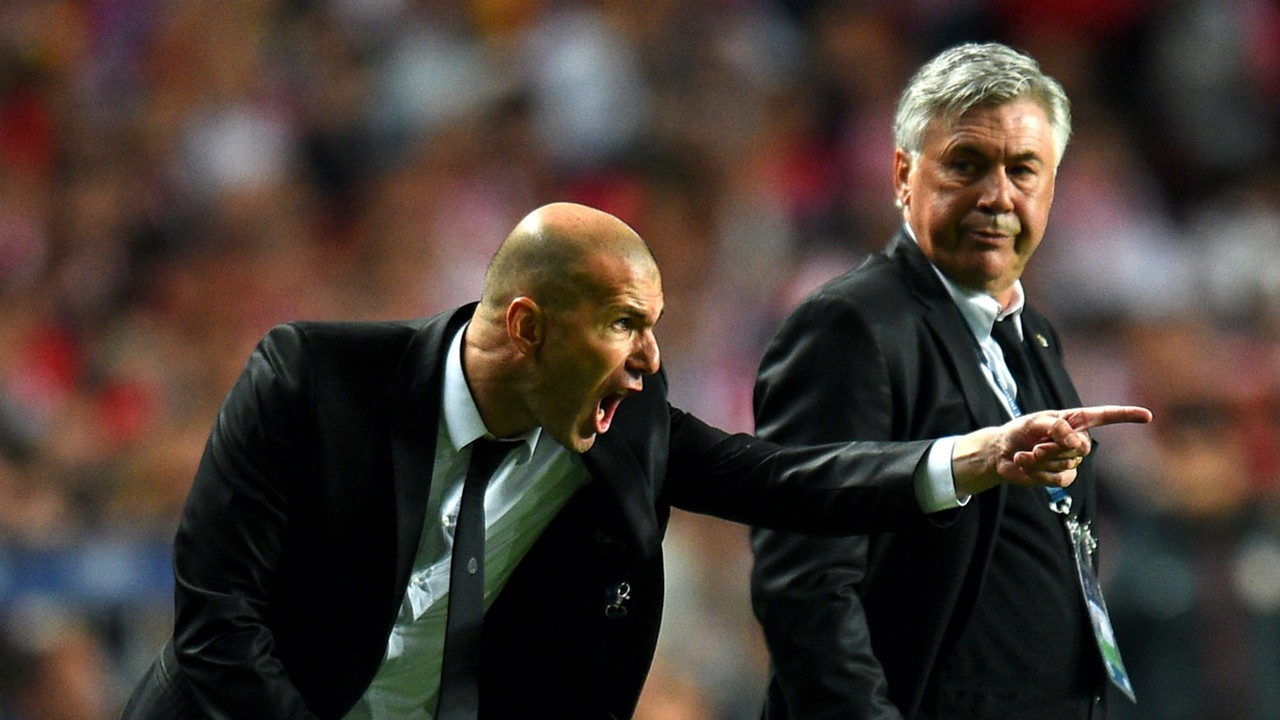

In [ ]:
### 推論実行前の画像
Image(filename='/content/yolov5/data/images/zidane.jpg', width=600)

推論を実行するともとの画像にBox、クラス名、confidenceを記載したjpgを出力します。  
jpgではなく、座標やクラス名などのテキストの結果が欲しい場合はオプションを指定することにより出力が可能です。  
そのオプションはコンペデータに対して推論する際に説明します。

detect: weights=['yolov5s.pt'], source=data/images/, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-25-g15e8c4c torch 1.9.0+cu111 CUDA:0 (Tesla K80, 11441.1875MB)

100% 14.0M/14.0M [00:00<00:00, 72.0MB/s]

Fusing layers... 
Model Summary: 213 layers, 7225885 parameters, 0 gradients
image 1/2 /content/yolov5/data/images/bus.jpg: 640x480 4 persons, 1 bus, Done. (0.033s)
image 2/2 /content/yolov5/data/images/zidane.jpg: 384x640 2 persons, 1 tie, Done. (0.030s)
Speed: 0.5ms pre-process, 31.7ms inference, 7.6ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


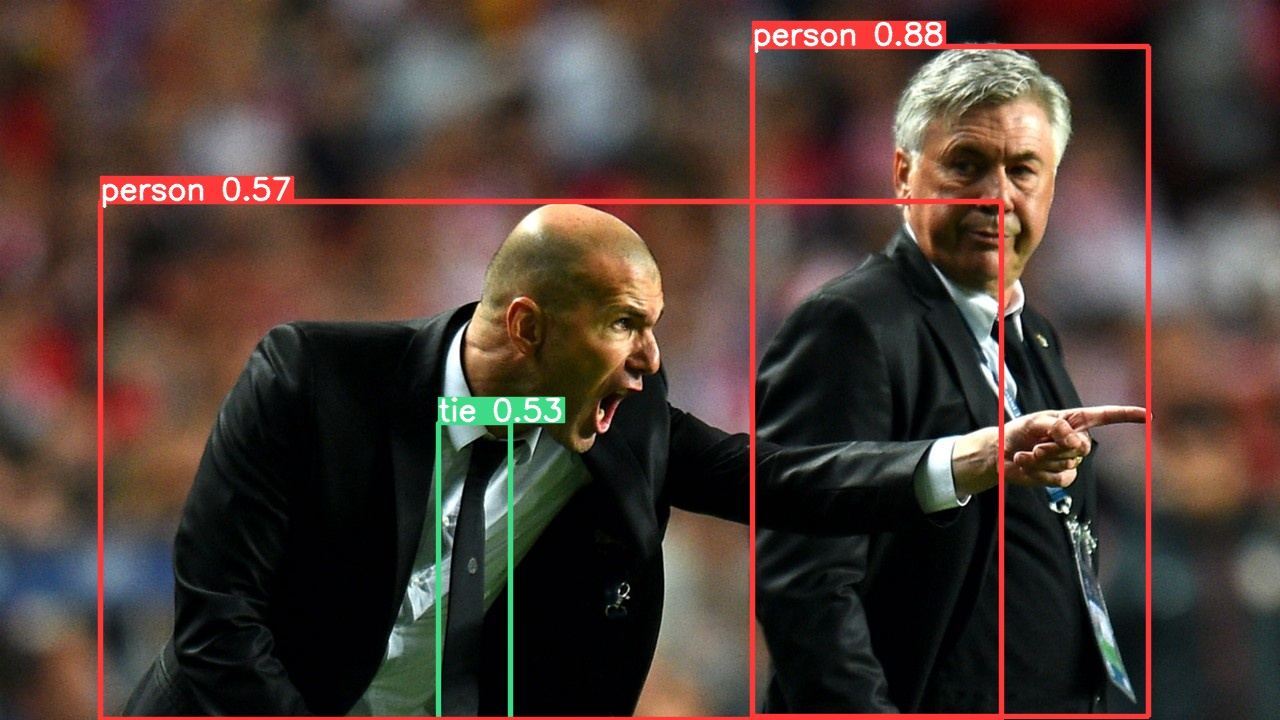

In [64]:
# 推論の実行
### 推論時にはオプションで以下を指定します。
### 学習済み重みデータ、imgのサイズ、ボックスを表示させるconfidenceのしきい値、推論対象のデータ
!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source data/images/
Image(filename='runs/detect/exp/zidane.jpg', width=600)

### 動作チェックが完了したところで今回のコンペのデータに対して学習を行っていきます

In [48]:
### 学習パラメータの設定
dim=512
batch_size=8
epochs = 5

yolo_ver = "yolov5x"

In [65]:
# コンペデータに対して学習を実行
### --dataオプションでsanwa.yamlを指定すると上記で作成したデータに対して学習が行なえます。
### yolov5 は s,m,l,xと複数のバージョンが有るのですが、--weightsオプションでバージョン指定を行えます。 s,m,l,xの順で性能がよいとされております。
### 詳しくはgitを参照してください。https://github.com/ultralytics/yolov5
!WANDB_MODE="dryrun" python train.py --img $dim --batch $batch_size --epochs $epochs --data /content/sanwa_extract.yaml --weights yolov5x.pt --cache

train: weights=yolov5x.pt, cfg=, data=/content/sanwa_extract.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=5, batch_size=8, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-25-g15e8c4c torch 1.9.0+cu111 CUDA:0 (Tesla K80, 11441.1875MB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, 

In [55]:
!dir /content/

additional_resize_jpg.zip  sample_data		train.cache	      val.txt
datasets		   sanwa_extract.yaml	train_resize_jpg.zip  yolov5
drive			   test_resize_jpg.zip	train.txt


### 

### train実行結果の保存
train.pyを実行すると、"/content/yolov5/runs/train/exp/"に対してepochごとのlossや学習した重みデータなどの情報が出力されます。  
このnotebookではcontentで動作させており、colabのセッションを切ると出力結果も失われてしまうため、マイドライブへコピーしておきます

In [71]:
import datetime
from distutils.dir_util import copy_tree

now = datetime.datetime.now()
current_time = now.strftime("%Y-%m-%d-%H-%M")

src = "/content/yolov5/runs/train/exp3/"

dest = f"{OUTPUT}models/yolo/{yolo_ver}_epoch{epochs}_{current_time}/train_log_extract"
if not os.path.exists(dest):
    os.makedirs(dest)

copy_tree(src, dest)


['/content/drive/My Drive/Python/Kaggle/nishika/output/models/yolo/yolov5x_epoch5_2021-10-21-09-04/train_log_extract/val_batch0_pred.jpg',
 '/content/drive/My Drive/Python/Kaggle/nishika/output/models/yolo/yolov5x_epoch5_2021-10-21-09-04/train_log_extract/P_curve.png',
 '/content/drive/My Drive/Python/Kaggle/nishika/output/models/yolo/yolov5x_epoch5_2021-10-21-09-04/train_log_extract/results.png',
 '/content/drive/My Drive/Python/Kaggle/nishika/output/models/yolo/yolov5x_epoch5_2021-10-21-09-04/train_log_extract/labels_correlogram.jpg',
 '/content/drive/My Drive/Python/Kaggle/nishika/output/models/yolo/yolov5x_epoch5_2021-10-21-09-04/train_log_extract/train_batch1.jpg',
 '/content/drive/My Drive/Python/Kaggle/nishika/output/models/yolo/yolov5x_epoch5_2021-10-21-09-04/train_log_extract/hyp.yaml',
 '/content/drive/My Drive/Python/Kaggle/nishika/output/models/yolo/yolov5x_epoch5_2021-10-21-09-04/train_log_extract/F1_curve.png',
 '/content/drive/My Drive/Python/Kaggle/nishika/output/models

## YOLO 推論
detect.pyで推論を行います。  
### オプションについて
* --sourceオプション : 推論したいデータを指定
* --weightsオプション : 先程学習した重みデータを指定します。
* --imgオプション : 推論する画像サイズの指定
* --confオプション : BOXを表示するしきい値の設定
    * **0.5と大きな値を設定してしまうとBOXが出力されないケースもあるため0.001と低い値を設定しております**
* --save-txtオプション : txtファイルで推論結果を出力するためのオプション。特にパラメータ設定はいらず--save-txtと記述するだけでOKです。
    * 推論実行後の構成は以下の様になり、jpgにはBOXつきの画像、txtに座標データが出力されます
    ```
    /content/yolov5/runs/detect/
    └── exp
        ├── bus.jpg
        └── zidane.jpg
        └── labels
                ├── bus.txt
                └── zidane.txt
    ```
* --save-confオプション : 上記のtxtファイルにconfidenceが出力されます。


In [81]:
!python detect.py --source "../datasets/additional_data" --weights '/content/yolov5/runs/train/exp3/weights/best.pt' --img 512 --conf 0.001 --save-txt --save-conf

### マイドライブから重みデータの読み込み
#!python detect.py --source "../datasets/test" --weights '/content/drive/My Drive/python/CableIdentification/output/models/yolo/yolov5x_epoch5/weights/best.pt' --img 512 --conf 0.01 --save-txt --save-conf

detect: weights=['/content/yolov5/runs/train/exp3/weights/best.pt'], source=../datasets/additional_data, imgsz=[512, 512], conf_thres=0.001, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-25-g15e8c4c torch 1.9.0+cu111 CUDA:0 (Tesla K80, 11441.1875MB)

Fusing layers... 
Model Summary: 444 layers, 86173414 parameters, 0 gradients, 204.0 GFLOPs
image 1/1648 /content/datasets/additional_data/00037f39.jpg: 512x512 28 connectors, Done. (0.194s)
image 2/1648 /content/datasets/additional_data/000f21ac.jpg: 512x512 44 connectors, Done. (0.169s)
image 3/1648 /content/datasets/additional_data/00328ce5.jpg: 512x512 34 connectors, Done. (0.156s)
image 4/1648 /content/datasets/additional_data/0038263c.jpg: 512x512 22 

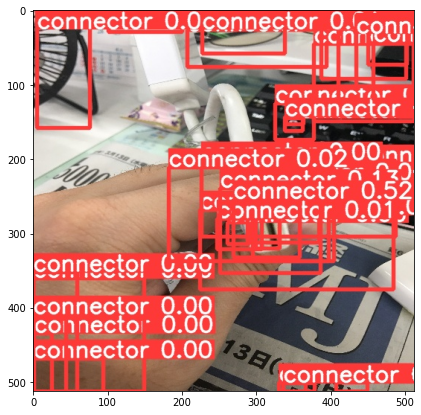

In [82]:
### 推論実行後の画像例
### thを0.001と非常に小さくしているためBOXがたくさん表示されます。
plot_img( read_img("/content/yolov5/runs/detect/exp7/edee29f8.jpg"))

In [83]:
### テキストでの推論結果
with open("/content/yolov5/runs/detect/exp7/labels/edee29f8.txt", mode="r") as f:
    data_ = f.read()
data_

'0 0.685547 0.291992 0.101562 0.0957031 0.00101972\n0 0.0253906 0.923828 0.046875 0.152344 0.00104853\n0 0.538086 0.584961 0.0566406 0.0566406 0.00108398\n0 0.868164 0.422852 0.0371094 0.0410156 0.00111006\n0 0.675781 0.585938 0.199219 0.144531 0.00111295\n0 0.65625 0.52832 0.1875 0.162109 0.00118516\n0 0.586914 0.0771484 0.365234 0.142578 0.00118525\n0 0.145508 0.851562 0.291016 0.296875 0.00119688\n0 0.679688 0.988281 0.0703125 0.0234375 0.00120217\n0 0.868164 0.189453 0.263672 0.203125 0.00131316\n0 0.835938 0.988281 0.0820312 0.0234375 0.00131469\n0 0.900391 0.126953 0.199219 0.253906 0.00137287\n0 0.293945 0.0283203 0.193359 0.0566406 0.00138413\n0 0.867188 0.0898438 0.222656 0.179688 0.00139141\n0 0.697266 0.989258 0.0820312 0.0214844 0.00141069\n0 0.691406 0.62793 0.507812 0.208984 0.00162371\n0 0.0576172 0.84375 0.115234 0.3125 0.00166833\n0 0.615234 0.581055 0.0625 0.0878906 0.00172796\n0 0.686523 0.291016 0.0449219 0.015625 0.00183421\n0 0.696289 0.494141 0.509766 0.199219 0.

In [84]:
### 実行結果をMYDRIVEへコピー

from distutils.dir_util import copy_tree
src = "/content/yolov5/runs/detect/exp7/"

dest = f"{OUTPUT}models/yolo/{yolo_ver}_epoch{epochs}_{current_time}/result_inference_extract/"
if not os.path.exists(dest):
    os.makedirs( dest)

copy_tree(src, dest)


['/content/drive/My Drive/Python/Kaggle/nishika/output/models/yolo/yolov5x_epoch5_2021-10-21-09-04/result_inference_extract/313c938e.jpg',
 '/content/drive/My Drive/Python/Kaggle/nishika/output/models/yolo/yolov5x_epoch5_2021-10-21-09-04/result_inference_extract/f4466a4b.jpg',
 '/content/drive/My Drive/Python/Kaggle/nishika/output/models/yolo/yolov5x_epoch5_2021-10-21-09-04/result_inference_extract/9cfd3c75.jpg',
 '/content/drive/My Drive/Python/Kaggle/nishika/output/models/yolo/yolov5x_epoch5_2021-10-21-09-04/result_inference_extract/67c31233.jpg',
 '/content/drive/My Drive/Python/Kaggle/nishika/output/models/yolo/yolov5x_epoch5_2021-10-21-09-04/result_inference_extract/c3114e3f.jpg',
 '/content/drive/My Drive/Python/Kaggle/nishika/output/models/yolo/yolov5x_epoch5_2021-10-21-09-04/result_inference_extract/3837e1aa.jpg',
 '/content/drive/My Drive/Python/Kaggle/nishika/output/models/yolo/yolov5x_epoch5_2021-10-21-09-04/result_inference_extract/736e537f.jpg',
 '/content/drive/My Drive/P

矩形Dataの中で確率が最大のものを残して残りを削除


In [28]:
!cp -r '/content/drive/My Drive/Python/Kaggle/nishika/output/models/yolo/yolov5x_epoch5_2021-10-21-09-04/result_inference_extract/labels' /content/

In [29]:
!rm -r /content/result_inference_extract/

In [55]:
extract_df=pd.DataFrame(index=[], columns=['cls', 'x', 'y', 'w', 'h', 'conf'])
for text in glob("/content/labels/*"):
  filename=text.split('/')[-1]
  filename=filename.replace('.txt','.jpg')
  df = pd.read_csv(text, sep='\s', names = ['cls', 'x', 'y', 'w', 'h', 'conf'])
  subdf=df.loc[[df['conf'].idxmax()]]
  subdf['filename']=filename
  extract_df=extract_df.append(subdf,ignore_index=True)
  #extract_df=pd.concat(extract_df,subdf)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


In [62]:
extract_df=extract_df[['filename','conf','x', 'y', 'w', 'h']]
extract_df

,filename,conf,x,y,w,h
0,01299ac6.jpg,0.499544,0.371094,0.449219,0.238281,0.105469
1,e2b79c6b.jpg,0.515308,0.547852,0.421875,0.240234,0.121094
2,de744131.jpg,0.426637,0.521484,0.519531,0.183594,0.246094
3,9512d95d.jpg,0.547752,0.603516,0.479492,0.140625,0.052734
4,40dd2b01.jpg,0.537380,0.520508,0.360352,0.169922,0.103516
...,...,...,...,...,...,...
1643,230ad27c.jpg,0.381818,0.575195,0.662109,0.326172,0.261719
1644,60f256c7.jpg,0.583159,0.491211,0.459961,0.189453,0.103516
1645,82607c98.jpg,0.505003,0.482422,0.465820,0.218750,0.111328
1646,802b906a.jpg,0.544013,0.495117,0.542969,0.146484,0.066406


In [63]:
df_additional
df_additional = pd.merge(df_additional, extract_df, on='filename')
df_additional=df_additional[['filename','class','path','x','y','w','h']]

In [84]:
def convert_reverse(size,x,y,w,h):
  box1=round((x-w/2)*size)
  box2=round((y-h/2)*size)
  box3=round((x+w/2)*size)
  box4=round((y+h/2)*size)
  returnstr='['+str(box1)+','+str(box2)+','+str(box3)+','+str(box4)+']'
  return returnstr

In [85]:
size=512
x=df_additional.loc[0,'x']
y=df_additional.loc[0,'x']
w=df_additional.loc[0,'w']
h=df_additional.loc[0,'h']

conv=convert_reverse(size,x,y,w,h)
print(conv)

[198,225,318,290]


In [92]:
for index,row in df_additional.iterrows():
  x=row['x']
  y=row['y']
  w=row['w']
  h=row['h']
  size=512
  conv=convert_reverse(size,x,y,w,h)
  #row['resized_box']=conv
  df_additional.loc[index,'resized_box']=conv
  #print(conv)

In [94]:
df_additional=df_additional[['filename','class','resized_box','path']]

In [95]:
df_additional

,filename,class,resized_box,path
0,172e1676.jpg,USB_Micro_B_W,"[198,237,318,302]",/content/datasets/additional/172e1676.jpg
1,2ed927e9.jpg,USB_Mini,"[230,223,293,265]",/content/datasets/additional/2ed927e9.jpg
2,d62e1c29.jpg,HDMI,"[230,259,298,291]",/content/datasets/additional/d62e1c29.jpg
3,e0ccc43c.jpg,VGA,"[191,204,308,256]",/content/datasets/additional/e0ccc43c.jpg
4,d6a40317.jpg,Lightning_T,"[197,269,297,332]",/content/datasets/additional/d6a40317.jpg
...,...,...,...,...
1643,1a42d526.jpg,Lightning,"[218,240,285,280]",/content/datasets/additional/1a42d526.jpg
1644,6b3c238e.jpg,USB_Type_C,"[236,232,345,394]",/content/datasets/additional/6b3c238e.jpg
1645,587a4905.jpg,USB_Mini,"[195,188,279,235]",/content/datasets/additional/587a4905.jpg
1646,ae600959.jpg,USB_Type_C,"[217,233,307,274]",/content/datasets/additional/ae600959.jpg


In [96]:
df_additional.to_csv(MYDRIVE+'/additional_with_box.csv')

In [72]:
df_train

,filename,Xmin_Ymin_Xmax_Ymax,class,resized_box,path,connector,fold
0,2f71963a,"[921, 1510, 1558, 2207]",HDMI,"[156, 192, 264, 280]",/content/datasets/train/2f71963a.jpg,connector,1
1,8cdf4bda,"[1442, 1525, 1722, 2000]",USB_Mini,"[244, 194, 292, 254]",/content/datasets/train/8cdf4bda.jpg,connector,3
2,7ac35f30,"[666, 1671, 1990, 2259]",Dock,"[113, 212, 337, 287]",/content/datasets/train/7ac35f30.jpg,connector,0
3,f6641c06,"[1242, 1753, 1789, 2115]",Lightning,"[210, 223, 303, 269]",/content/datasets/train/f6641c06.jpg,connector,2
4,4fdc8d7d,"[1572, 1050, 2231, 1691]",USB_Micro_B,"[266, 133, 378, 215]",/content/datasets/train/4fdc8d7d.jpg,connector,0
...,...,...,...,...,...,...,...
2366,f51ca7d8,"[678, 1276, 2088, 2355]",USB_Type_B,"[115, 162, 354, 299]",/content/datasets/train/f51ca7d8.jpg,connector,3
2367,323b4f3c,"[1564, 2003, 2116, 2307]",USB_Type_C,"[267, 256, 361, 295]",/content/datasets/train/323b4f3c.jpg,connector,2
2368,5f60288f,"[1273, 1816, 2275, 2784]",RJ_45,"[216, 231, 385, 354]",/content/datasets/train/5f60288f.jpg,connector,2
2369,eaea09d6,"[863, 1838, 1213, 2054]",USB_Micro_B,"[205, 245, 288, 274]",/content/datasets/train/eaea09d6.jpg,connector,2


In [77]:
df_train.loc[0,'resized_box'][0]

156

## submission.csvの作成
yolov5で推論したclassをdfに追記してsubmission.csvを作成します。

* labelsのフォーマットについて https://github.com/ultralytics/yolov5/blob/master/detect.pyから確認。
    * 1ラインにつき、(cls, x, y, w, h, conf)のフォーマット。
    * non_max_suppression関数によって、confidence順でソートされており、一番最後の行が一番確信度の高いBOXになる。
* 複数あるBOXの中でconfidenceが一番高いBOXを採用し、dfにclassと座標を追記
    * yoloで出力された座標形式からxmin,ymin,xmax,ymaxの形式へ戻しておく。

In [ ]:
def yolo2voc(image_height, image_width, bboxes):
    """
    yolo => [xmid, ymid, w, h] (0~1)
    voc  => [xmin, ymin, xmax, ymax]

    """ 
    bboxes = bboxes.copy().astype(float) 

    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]* image_height

    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    bboxes[..., [2, 3]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]

    return bboxes

file_ids = []
PredictionStrings = []

for file_path in tqdm(glob('/content/yolov5/runs/detect/exp2/labels/*.txt')):
    file_id = file_path.split('/')[-1].split('.')[0]
    w, h = 512,512
    f = open(file_path, 'r')
    data = np.array(f.read().replace('\n', ' ').strip().split(' ')).astype(np.float32).reshape(-1, 6)

    ### yoloでの推論結果は1つの　BOXにつき(cls, x, y, w, h, conf)の順で表示されるので(cls, conf, x, y, w, h)へ直しておく。
    ### BOXが複数出力される場合は、低い順に表示される
    data = data[:, [0, 5, 1, 2, 3, 4]]
    bboxes = list(np.round(np.concatenate((data[:, :2], np.round(yolo2voc(h, w, data[:, 2:]))), axis =1).reshape(-1), 12).astype(str))
    for idx in range(len(bboxes)):
        bboxes[idx] = str(int(float(bboxes[idx]))) if idx%6!=1 else bboxes[idx]
    file_ids.append(file_id)
    PredictionStrings.append(' '.join(bboxes))

pred_df = pd.DataFrame({'id':file_ids,
                        'PredictionString':PredictionStrings})

  0%|          | 0/2200 [00:00<?, ?it/s]

In [ ]:
class_ls = []
max_conf_ls = []
box_ls = []

for predstring in tqdm(pred_df["PredictionString"].values):
    listfromstr = predstring.split(" ")

    class_ls.append( int(listfromstr[-6]) )
    max_conf_ls.append( float(listfromstr[-5]) )
    box_ls.append( [int(x) for x in listfromstr[-4:] ] )

pred_df["classID"] = class_ls
pred_df["cofidence"] = max_conf_ls
pred_df["box"] = box_ls


  0%|          | 0/2200 [00:00<?, ?it/s]

In [ ]:
pred_df["class"] = pred_df["classID"].apply(lambda x: dict_label[x])

In [ ]:
pred_df["filename"] = pred_df["id"].apply(lambda x: x+".jpg")

In [ ]:
pred_df

,id,PredictionString,classID,cofidence,box,class,filename
0,7a7e0649,2 0.001036740025 243 288 351 337 7 0.001213449...,14,0.345202,"[173, 226, 349, 268]",VGA,7a7e0649.jpg
1,63d4119d,12 0.001010469976 216 185 315 275 4 0.00104273...,12,0.382681,"[234, 179, 376, 290]",USB_Type_B,63d4119d.jpg
2,c3e64604,8 0.00108632003 0 0 512 512 7 0.001207940048 1...,7,0.282860,"[216, 295, 313, 354]",USB_Micro_B,c3e64604.jpg
3,d130a946,11 0.00102188997 155 171 315 283 11 0.00113741...,11,0.512721,"[192, 176, 342, 245]",USB_Type_A,d130a946.jpg
4,f9b7214e,4 0.001057590009 433 244 512 410 7 0.001166439...,7,0.340208,"[240, 136, 356, 299]",USB_Micro_B,f9b7214e.jpg
...,...,...,...,...,...,...,...
2195,593a9691,13 0.00101928995 0 249 159 426 13 0.0011093800...,7,0.152046,"[100, 247, 180, 303]",USB_Micro_B,593a9691.jpg
2196,aa273a29,7 0.001053779968 0 166 39 298 4 0.001167280017...,7,0.438942,"[209, 126, 320, 181]",USB_Micro_B,aa273a29.jpg
2197,798001d1,13 0.001001839992 18 0 204 35 4 0.001060290029...,4,0.410742,"[163, 181, 380, 277]",Lightning_T,798001d1.jpg
2198,79b9ca14,7 0.00132159004 219 250 254 294 13 0.001459290...,7,0.482612,"[182, 238, 289, 285]",USB_Micro_B,79b9ca14.jpg


In [ ]:
pred_df.to_csv(f"{OUTPUT}models/yolo/{yolo_ver}_epoch{epochs}_{current_time}/pred_yolo1.csv")

In [ ]:
submission = pred_df[["filename","class"]]

In [ ]:
submission

,filename,class
0,7a7e0649.jpg,VGA
1,63d4119d.jpg,USB_Type_B
2,c3e64604.jpg,USB_Micro_B
3,d130a946.jpg,USB_Type_A
4,f9b7214e.jpg,USB_Micro_B
...,...,...
2195,593a9691.jpg,USB_Micro_B
2196,aa273a29.jpg,USB_Micro_B
2197,798001d1.jpg,Lightning_T
2198,79b9ca14.jpg,USB_Micro_B


In [ ]:
submission.to_csv(f"{OUTPUT}models/yolo/{yolo_ver}_epoch{epochs}_{current_time}/submission2.csv", index=False)

# EOF
